In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import math
from datetime import datetime, timedelta

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pd.set_option('display.max_columns', None)

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

In [5]:
stations_point = gpd.read_file('../data/processed/stations_point.geojson')
stations_area = gpd.read_file('../data/processed/stations_area.geojson')
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson')

In [6]:
pred_df = pd.read_csv('../data/processed/neighbourhoods_prediction.csv')
pred_df['hood_id'] = pred_df['hood_id'].astype(str)
neighbourhoods_pred = neighbourhoods[['hood_id' , 'geometry']].drop_duplicates().merge(pred_df, on='hood_id')
neighbourhoods_pred

,hood_id,geometry,Time,RoomType,AvgLeaseRatePerRoom,MCI_rate,collision_rate
0,1,"POLYGON ((-79.55235 43.70947, -79.55237 43.709...",2022.25,SharedApartments,1080.745780,578.831539,875.556484
1,1,"POLYGON ((-79.55235 43.70947, -79.55237 43.709...",2022.50,SharedApartments,1092.437228,578.831539,899.005564
2,1,"POLYGON ((-79.55235 43.70947, -79.55237 43.709...",2022.75,SharedApartments,1104.128676,578.831539,915.551461
3,1,"POLYGON ((-79.55235 43.70947, -79.55237 43.709...",2023.00,SharedApartments,1115.820124,578.831539,927.145956
4,10,"POLYGON ((-79.52678 43.65094, -79.52687 43.650...",2022.25,SharedApartments,1289.385245,155.462629,177.289259
...,...,...,...,...,...,...,...
555,98,"POLYGON ((-79.36337 43.67532, -79.36423 43.675...",2023.00,SharedApartments,1846.474227,246.517169,405.205344
556,99,"POLYGON ((-79.37747 43.71309, -79.37737 43.712...",2022.25,SharedApartments,1563.032422,113.468550,582.293772
557,99,"POLYGON ((-79.37747 43.71309, -79.37737 43.712...",2022.50,SharedApartments,1574.723870,113.468550,592.228445
558,99,"POLYGON ((-79.37747 43.71309, -79.37737 43.712...",2022.75,SharedApartments,1586.415318,113.468550,597.581675


Text(0.5, 402.2439061168173, 'Longitude')

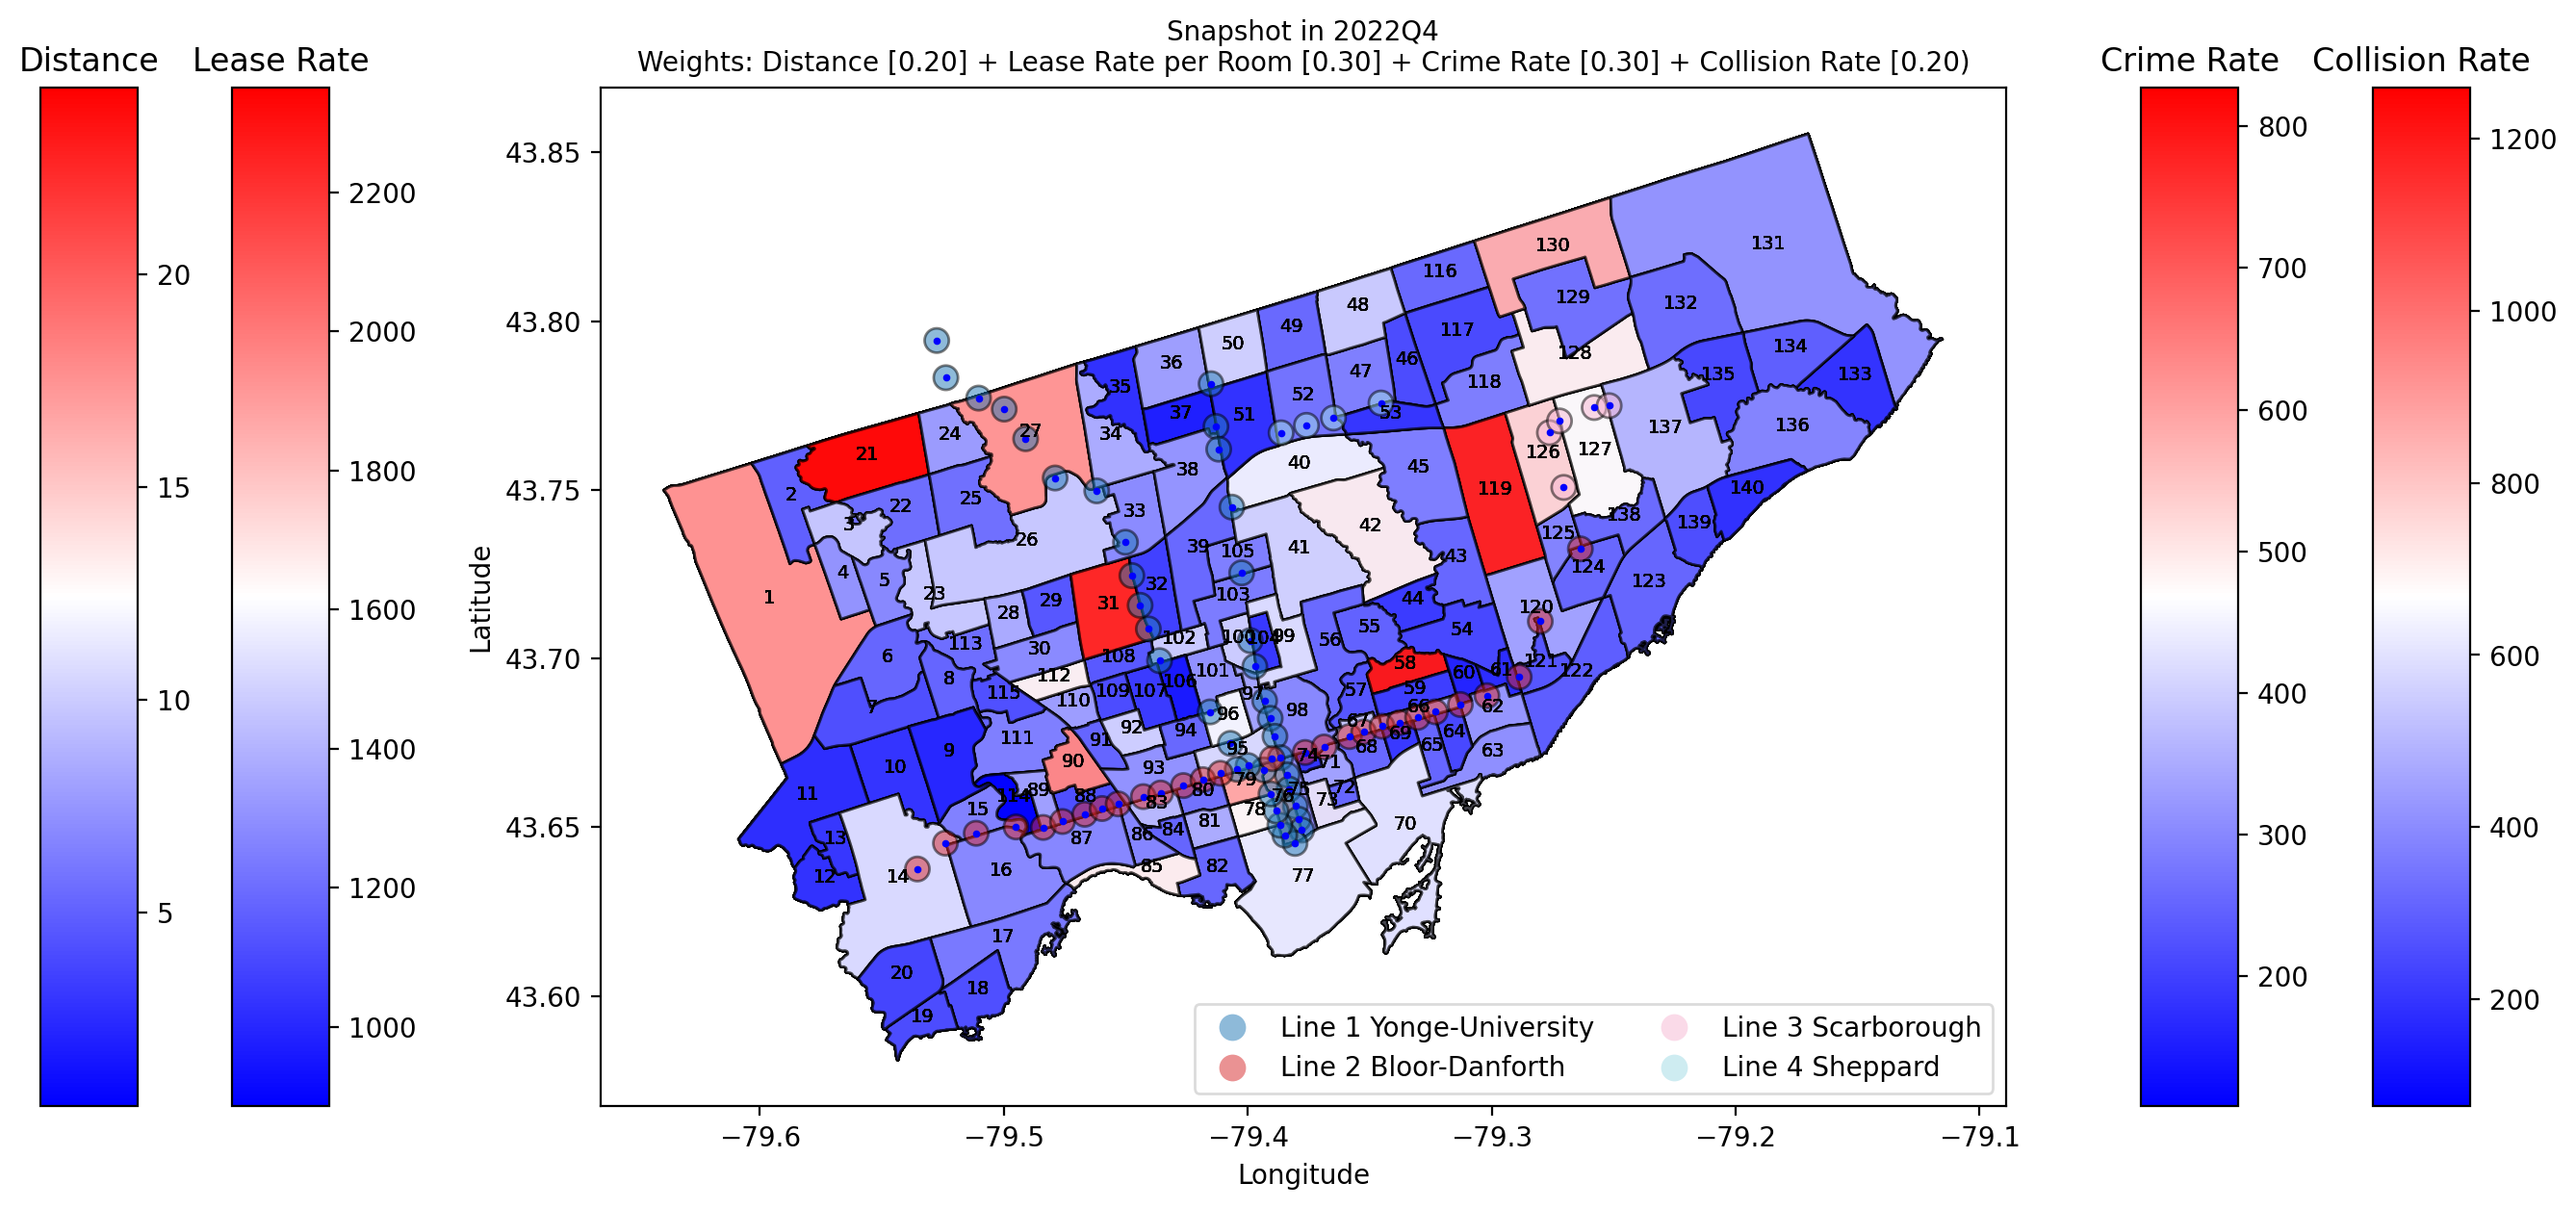

In [37]:
max_date = datetime(int(neighbourhoods_pred['Time'].max()),1,1) + timedelta(days=-1 + (365*(neighbourhoods_pred['Time'].max()-int(neighbourhoods_pred['Time'].max()))))
year = max_date.year
quarter = round(max_date.month/3)

# weights for coloring
alphas = {'distance': 0.2,
          'rent': 0.3,
          'safety': 0.3,
        #   'safety_homicide': 0.05,
        #   'safety_shootings': 0.05,
          'traffic': 0.2}

# alphas = {'distance': 0,
#           'rent': 0,
#           'safety': 0.3,
#           'safety_homicide': 0,
#           'safety_shootings': 0,
#           'traffic': 0}

# multiplier for better contrast
multiplier = 3
for key, value in alphas.items():
    alphas[key] = value * multiplier

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=1)
cax.title.set_text('Distance')
neighbourhoods.plot(column='distance_km',
                    cmap= 'bwr',
                    edgecolor='black',
                    alpha=alphas['distance'],
                    ax=ax,
                    cax=cax,
                    legend=True,
                    )
# annotate neighbourhood names
for geometry, label in zip(neighbourhoods.geometry, neighbourhoods.hood_id):
    ax.annotate(label, xy=(geometry.centroid.x, geometry.centroid.y),
                ha='center', size='x-small')


cax2 = divider.append_axes("left", size="5%", pad=-1.5)
cax2.title.set_text('Lease Rate')
neighbourhoods_pred.plot(column='AvgLeaseRatePerRoom',
                   cmap='bwr',
                   edgecolor='black',
                   alpha=alphas['rent'],
                   ax=ax,
                   cax=cax2,
                   legend=True,
                   )


cax3 = divider.append_axes("right", size="5%", pad=-0.7)
cax3.title.set_text('Crime Rate')
neighbourhoods_pred.plot(column='MCI_rate',
                    cmap='bwr',
                    edgecolor='black',
                    alpha=alphas['safety'],
                    ax=ax,
                    cax=cax3,
                    legend=True
                    )

# var = "Homicide"
# selected_crime = neighbourhoods_crime.loc[(neighbourhoods_crime['occurrence_year'] == year) &
#                                           (neighbourhoods_crime['occurrence_quarter'] == quarter) &
#                                           (neighbourhoods_crime['MCI'] == var) &
#                                           (neighbourhoods_crime['type'] == 'rate')]
# selected_crime.plot(column='value',
#                     cmap='bwr',
#                     edgecolor='black',
#                     alpha=alphas['safety_homicide'],
#                     ax=ax,
#                     #   cax = cax3,
#                     #   legend = True
#                     )

# var = "Shootings"
# selected_crime = neighbourhoods_crime.loc[(neighbourhoods_crime['occurrence_year'] == year) &
#                                           (neighbourhoods_crime['occurrence_quarter'] == quarter) &
#                                           (neighbourhoods_crime['MCI'] == var) &
#                                           (neighbourhoods_crime['type'] == 'rate')]
# selected_crime.plot(column='value',
#                     cmap='bwr',
#                     edgecolor='black',
#                     alpha=alphas['safety_shootings'],
#                     ax=ax,
#                     #   cax = cax3,
#                     #   legend = True
#                     )

cax4 = divider.append_axes("right", size="5%", pad=0.7)
cax4.title.set_text('Collision Rate')
neighbourhoods_pred.plot(column='collision_rate',
                        cmap='bwr',
                        edgecolor='black',
                        alpha=alphas['traffic'],
                        ax=ax,
                        cax=cax4,
                        legend=True)

stations_area.plot(column='line',
                   edgecolor='black',
                   alpha=0.5,
                   cmap='tab20',
                   legend=True,
                   legend_kwds={'loc': 'lower right',
                                'ncol': 2,
                                'edgecolor': 'lightgrey'},
                   ax=ax)
stations_point.plot(ax=ax,
                    color='blue',
                    markersize=3)

# reset the alphas to their original values
for key, value in alphas.items():
    alphas[key] = value / multiplier

# ax.set_title(f"Snapshot in {year}Q{quarter}\nWeights: Distance [{alphas['distance']:0.2f}] + Lease Rate per Room [{alphas['rent']:0.2f}] + Crime Rate [{alphas['safety']:0.2f}] + Collision Rate [{alphas['traffic']:0.2f})\n(+ Homicide Rate [{alphas['safety_homicide']:0.2f}] + Shootings Rate [{alphas['safety_shootings']:0.2f}])",
#              size='medium')
ax.set_title(f"Snapshot in {year}Q{quarter}\nWeights: Distance [{alphas['distance']:0.2f}] + Lease Rate per Room [{alphas['rent']:0.2f}] + Crime Rate [{alphas['safety']:0.2f}] + Collision Rate [{alphas['traffic']:0.2f})",
             size='medium')
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
